In [17]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [18]:
#!/usr/bin/env python
from __future__ import division
from builtins import str
from builtins import range
from past.utils import old_div
import numpy as np
import datetime
import pickle
from netCDF4 import Dataset
import sys
import matplotlib.pyplot as plt
from chaz import CLE15, utility
from pygplib import readbst
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
from scipy.interpolate import griddata
from pyproj import Proj, transform

In [19]:
### constant from Dan Chavas ###
fcor = 5.e-5  # [s-1] {5e-5}; Coriolis parameter at storm center
# Environmental parameters
# Outer region
# [-] {1}; 0 : Outer region Cd = constant (defined on next line); 1 : Outer region Cd = f(V) (empirical Donelan et al. 2004)
Cdvary = 1
# [-] {1.5e-3}; ignored if Cdvary = 1; surface momentum exchange (i.e. drag) coefficient
Cd = 1.5e-3
# [ms-1] {2/1000; Chavas et al 2015}; radiative-subsidence rate in the rain-free tropics above the boundary layer top
w_cool = 2./1000

# Inner region
# [-] {1}; 0 : Inner region Ck/Cd = constant (defined on next line); 1 : Inner region Ck/Cd = f(Vmax) (empirical Chavas et al. 2015)
CkCdvary = 1
# [-] {1}; ignored if CkCdvary = 1; ratio of surface exchange coefficients of enthalpy and momentum; capped at 1.9 (things get weird >=2)
CkCd = 1.

# Eye adjustment
eye_adj = 0  # [-] {1}; 0 = use ER11 profile in eye; 1 = empirical adjustment
# [-] {.15; empirical Chavas et al 2015}; V/Vm in eye is reduced by factor (r/rm)^alpha_eye; ignored if eye_adj=0
alpha_eye = .15
###

In [20]:
# LOCATION INFORMATION
cityName = 'Manila' #'Bermuda'
lat_poi = 14.5995 #32.307
lon_poi = 120.9842 #-64.7505+360.
radius = 600.  # km Haiyan is storm 660 with this radius.
er = 6371.0  # km

In [21]:
# read data
fileName = '/data2/clee/bttracks/Allstorms.ibtracs_all.v03r10.nc'
ibtracs = readbst.read_ibtracs(fileName, 'wnp')
ipoi = utility.find_poi_Tracks(ibtracs.lon[:, :], ibtracs.lat[:, :], ibtracs.wspd[:, :],
                               lon_poi, lat_poi, radius)
lon = ibtracs.lon[:, ipoi]
lat = ibtracs.lat[:, ipoi]
wspd = ibtracs.wspd[:, ipoi]
days = ibtracs.days[:, ipoi]
dist2land = ibtracs.dist2land[:, ipoi]
year = ibtracs.year[ipoi]
tt = np.empty(wspd.shape, dtype=object)
count = 0
for i in range(ipoi.shape[0]):
    for j in range(wspd.shape[0]):
        if days[j, i] == days[j, i]:
            tt[j, count] = datetime.datetime(
                1858, 11, 17, 0, 0)+datetime.timedelta(days=days[j, i])
    count += 1
lon_diff = lon[1:, :]-lon[0:-1, :]
lat_diff = lat[1:, :]-lat[0:-1, :]
londis = old_div(2*np.pi*er*np.cos(old_div(lat[1:, :],180)*np.pi),360)
dx = londis*lon_diff
dy = 110.*lat_diff
days_diff = (days[1:, :] - days[0:-1, :])*24.
tr = old_div(np.sqrt(dx**2+dy**2),(days_diff)) # track translation speed?
trDir = np.arctan2(lat_diff, lon_diff)
#tr1 = np.zeros(wspd.shape)*np.float('nan')
#trDir1 = np.zeros(wspd.shape)*np.float('nan')
# for iS in range(ipoi.shape[0]):
#    iT = np.argwhere(np.isnan(lon[:,iS])).flatten()[-1]+1
#    trDir1[:iT,iS],tr1[:iT,iS] =\
#        utility.getStormTranslation(lon[:iT,iS],lat[:iT,iS],tt[:iT,iS])
rmax = utility.knaff15(wspd, lat)*1000.  # meter
# tr1 = tr1*3.6 #km/hr

[10] wnp
(2071,)


2013-11-02 06:00:00 [165. 145. 130. 120. 115.]
660 [23 24 25 26 27]


/home/jbaldwin/lib/python/chaz/CLE15.py:103: RuntimeWarning: divide by zero encountered in true_divide
  V_ER11 = (1./rr_ER11)*(Vmax*rmax + .5*fcor*rmax**2)*(old_div((2*(old_div(rr_ER11, rmax))**2),
/home/jbaldwin/lib/python/chaz/CLE15.py:104: RuntimeWarning: invalid value encountered in multiply
  (2-CkCd+CkCd*(old_div(rr_ER11, rmax))**2)))**(old_div(1, (2-CkCd))) - .5*fcor*rr_ER11
/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b


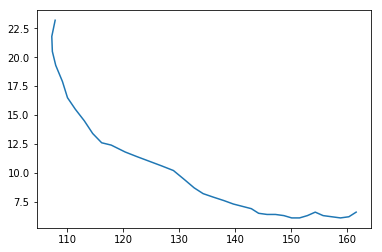

In [6]:
# STANDARD CALCULATION OF WIND FIELDS
v_poi = []
wspd_poi = []
rmw_poi = []
wspd_poi_v2 = []
lon1 = []
lat1 = []
for iS in range(660,661): #range(lon.shape[1]):
    iipoi = utility.find_timing_Tracks(
        lon[:, iS], lat[:, iS], wspd[:, iS], lon_poi, lat_poi, radius)
    if iipoi.size > 0:
        plt.plot(lon[:, iS], lat[:, iS])
        print(tt[0, iS], wspd[iipoi, iS])
        londis = old_div(2*np.pi*er*np.cos(old_div(lat[iipoi, iS],180)*np.pi),360)
        dx = londis*(lon[iipoi, iS]-lon_poi)
        dy = 110*(lat[iipoi, iS]-lat_poi)
        distance = np.sqrt(dx*dx+dy*dy)
        distance[distance != distance] = radius+10000
        # for ii in iipoi:
        #	  if wspd[ii,iS]==-9990.:
        #	     wspd[ii,iS] = 25.
        wspd_poi.append(np.nanmax(wspd[iipoi, iS]))
        lon1.append(lon[iipoi[np.argmax(wspd[iipoi, iS])], iS])
        lat1.append(lat[iipoi[np.argmax(wspd[iipoi, iS])], iS])
        rmw_poi.append(rmax[iipoi[np.argmax(wspd[iipoi, iS])], iS])
        print(iS, iipoi)
        v_temp = []
        w_temp = []
        for ii in iipoi:
            if not np.isnan(tr[ii, iS]):
                wspd_az = wspd[ii, iS]/1.94384449 - tr[ii, iS]*0.7  # in ms-1
            else:
                wspd_az = wspd[ii, iS]/1.94384449

            # need to use ms-1
            rr, VV, r0, rmerge, Vmerge = CLE15.ER11E04_nondim_rmaxinput(wspd_az,
                                                                        rmax[ii,
                                                                             iS], fcor, Cdvary,
                                                                        Cd, w_cool, CkCdvary, CkCd, eye_adj, alpha_eye)
            # stop at 300Km
            ir = np.argwhere(rr <= (radius+50)*1000.)[-1, 0]
            V = np.zeros([ir, 360]) # create empty array with radii by 360 degrees
            V = np.reshape(np.repeat(VV[:ir], 360), V.shape) # take wind profile and tile it onto 360 degrees
            angle = np.arange(0., 360., 1.)/180.*np.pi+0.5*np.pi-trDir[ii, iS] # define angle relative to track direction 
            rFactor = utility.translationspeedFactor(old_div(rr[:ir],rmax[ii, iS]))
            vt = np.array([tr[ii, iS]*np.cos(angle[id]) for id in range(360)]) # tangential wind
            V = V+np.array([rFactor[iir]*vt for iir in range(ir)])
            londis = np.abs(old_div(2*np.pi*er*np.cos(lat[ii, iS]/180.*np.pi),360)) # distance of 1 deg longitude at storm latitude
            theta, rr1 = np.meshgrid(np.arange(0., 360., 1.), rr[:ir]/1000.) # make mesh grid (360 deg x radii) of values of angle and radius in wind field
            dlon = old_div(rr1*np.cos(theta/180.*np.pi),111) # translate distance along radius in direction to deg longitude
            dlat = old_div(rr1*np.sin(theta/180.*np.pi),londis) # translate distance along radius in direction to deg latitude
            vlon = lon[ii, iS]+dlon # longitude of each wind field point
            vlat = lat[ii, iS]+dlat # latitude of each wind field point
            dummy = np.sqrt(((vlon-lon_poi)*londis)**2+((vlat-lat_poi)*111)**2) # distance between wind field grid points and POI
            iir, iit = np.argwhere(dummy == dummy.min()).flatten() # find place in wind field closest to POI
            v_temp.append(V[iir, iit]*1.94384449) # 1.94384 --> convert m/s to knots
            w_temp.append(np.nanmax(V)*1.94384449) # 1.94384 --> convert m/s to knots
            # v_poi = griddata((vlon.flatten(),vlat.flatten()),V.flatten(),(lon_poi,lat_poi)
        v_poi.append(np.nanmax(np.array(v_temp)))
        wspd_poi_v2.append(
            np.nanmax([np.nanmax(np.array(w_temp)), np.nanmax(wspd[iipoi, iS])]))
    else:
        v_poi.append(float('nan'))
        wspd_poi.append(float('nan'))
        rmw_poi.append(float('nan'))
        wspd_poi_v2.append(float('nan'))
        lon1.append(float('nan'))
        lat1.append(float('nan'))


2013-11-02 06:00:00 [165. 145. 130. 120. 115.]
660 [23 24 25 26 27]


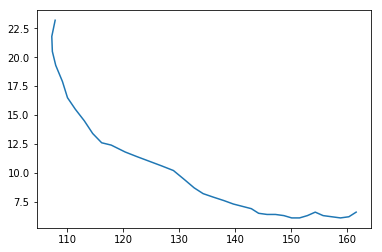

In [7]:
#EDITED TO COLLECT WIND FIELDS NEAR POI
v_poi = []
wspd_poi = []
rmw_poi = []
wspd_poi_v2 = []
lon1 = []
lat1 = []
for iS in range(660,661): #range(lon.shape[1]):
    iipoi = utility.find_timing_Tracks(
        lon[:, iS], lat[:, iS], wspd[:, iS], lon_poi, lat_poi, radius)
    iipoin = iipoi.size
    if iipoin > 0:
        plt.plot(lon[:, iS], lat[:, iS])
        print(tt[0, iS], wspd[iipoi, iS])
        londis = old_div(2*np.pi*er*np.cos(old_div(lat[iipoi, iS],180)*np.pi),360)
        dx = londis*(lon[iipoi, iS]-lon_poi)
        dy = 110*(lat[iipoi, iS]-lat_poi)
        distance = np.sqrt(dx*dx+dy*dy)
        distance[distance != distance] = radius+10000
        wspd_poi.append(np.nanmax(wspd[iipoi, iS]))
        lon1.append(lon[iipoi[np.argmax(wspd[iipoi, iS])], iS])
        lat1.append(lat[iipoi[np.argmax(wspd[iipoi, iS])], iS])
        rmw_poi.append(rmax[iipoi[np.argmax(wspd[iipoi, iS])], iS])
        print(iS, iipoi)
        v_temp = []
        w_temp = []
        irmax = 10000
        V = np.full([iipoin, irmax, 360],np.nan) # create empty array with storms by radii by 360 degrees
        vlon = np.full([iipoin, irmax, 360],np.nan) # create empty array with storms by radii by 360 degrees
        vlat = np.full([iipoin, irmax, 360],np.nan) # create empty array with storms by radii by 360 degrees
        iir = np.zeros([iipoin],dtype=int) # create empty array of locations of wind field closest to POI
        iit = np.zeros([iipoin],dtype=int) # create empty array of locations of wind field closest to POI
        for ii in iipoi:
            iin = ii-np.min(iipoi) # count on scale starting with 0
            if not np.isnan(tr[ii, iS]):
                wspd_az = wspd[ii, iS]/1.94384449 - tr[ii, iS]*0.7  # in ms-1
            else:
                wspd_az = wspd[ii, iS]/1.94384449

            # need to use ms-1
            rr, VV, r0, rmerge, Vmerge = CLE15.ER11E04_nondim_rmaxinput(wspd_az,
                                                                        rmax[ii,
                                                                             iS], fcor, Cdvary,
                                                                        Cd, w_cool, CkCdvary, CkCd, eye_adj, alpha_eye)
            # stop at 300Km
            ir = np.argwhere(rr <= (radius+50)*1000.)[-1, 0]
            V[iin,:ir,:] = np.reshape(np.repeat(VV[:ir], 360), [ir,360]) # take wind profile and tile it onto 360 degrees
            angle = np.arange(0., 360., 1.)/180.*np.pi+0.5*np.pi-trDir[ii, iS] # define angle relative to track direction 
            rFactor = utility.translationspeedFactor(old_div(rr[:ir],rmax[ii, iS]))
            vt = np.array([tr[ii, iS]*np.cos(angle[id]) for id in range(360)]) # tangential wind
            V[ii-np.min(iipoi),:ir,:] = V[ii-np.min(iipoi),:ir,:]+np.array([rFactor[iir]*vt for iir in range(ir)])
            londis = np.abs(old_div(2*np.pi*er*np.cos(lat[ii, iS]/180.*np.pi),360)) # distance of 1 deg longitude at storm latitude
            theta, rr1 = np.meshgrid(np.arange(0., 360., 1.), rr[:ir]/1000.) # make mesh grid (360 deg x radii) of values of angle and radius in wind field
            dlon = old_div(rr1*np.cos(theta/180.*np.pi),111) # translate distance along radius in direction to deg longitude
            dlat = old_div(rr1*np.sin(theta/180.*np.pi),londis) # translate distance along radius in direction to deg latitude
            vlon[iin,:ir,:] = lon[ii, iS]+dlon # longitude of each wind field point
            vlat[iin,:ir,:] = lat[ii, iS]+dlat # latitude of each wind field point
            dummy = np.sqrt(((vlon[iin,:ir,:]-lon_poi)*londis)**2+((vlat[iin,:ir,:]-lat_poi)*111)**2) # distance between wind field grid points and POI
            iir[iin], iit[iin] = np.argwhere(dummy == dummy.min()).flatten() # find place in wind field closest to POI
            v_temp.append(V[iin, iir[iin], iit[iin]]*1.94384449) # 1.94384 --> convert m/s to knots
            w_temp.append(np.nanmax(V[iin,:ir,:])*1.94384449) # 1.94384 --> convert m/s to knots
            # v_poi = griddata((vlon.flatten(),vlat.flatten()),V.flatten(),(lon_poi,lat_poi)
        v_poi.append(np.nanmax(np.array(v_temp)))
        wspd_poi_v2.append(
            np.nanmax([np.nanmax(np.array(w_temp)), np.nanmax(wspd[iipoi, iS])]))
    else:
        v_poi.append(float('nan'))
        wspd_poi.append(float('nan'))
        rmw_poi.append(float('nan'))
        wspd_poi_v2.append(float('nan'))
        lon1.append(float('nan'))
        lat1.append(float('nan'))

/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


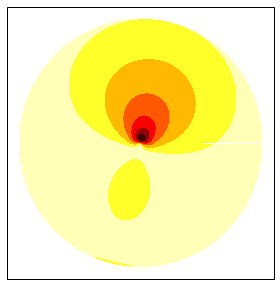

In [8]:
# Plot with original lat/lon
plt.figure(figsize=(15, 5))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
iin = 2
p1 = plt.contourf(vlon[iin,...],vlat[iin,...],np.abs(V[iin,...]),cmap=plt.cm.hot_r)

In [11]:
#Transform all points of wind field from lon-lat to meters

lon = vlon[2,...]
lat = vlat[2,...]

inProj = Proj(init='epsg:4326') #https://epsg.io/4326
outProj = Proj(init='epsg:3395') #https://epsg.io/3395, world map in meters
x1,y1 = lon,lat
x2,y2 = transform(inProj,outProj,x1,y1)

In [16]:
# GRID TO PUT EVERYTHING ON

X = np.arange(-180,180.1,0.1)
Y = np.arange(-80,80.1,0.1)
XV, YV = np.meshgrid(X,Y)

inProj = Proj(init='epsg:4326') #https://epsg.io/4326
outProj = Proj(init='epsg:3395') #https://epsg.io/3395, world map in meters
X1,Y1 = XV,YV
X2,Y2 = transform(inProj,outProj,X1,Y1)

In [17]:
# reformat for regridding

x2 = x2.flatten()
x2 = x2[~np.isnan(x2)]
y2 = y2.flatten()
y2 = y2[~np.isnan(y2)]
v2 = V[2,...].flatten()
v2 = v2[~np.isnan(v2)]

In [19]:
# regrid to regular lat-lon 

grid = griddata((x2, y2), v2, (X2, Y2), method='linear')

In [9]:
# FUNCTION TO REGRID WIND FIELDS

inProj = Proj(init='epsg:4326') #https://epsg.io/4326
outProj = Proj(init='epsg:3395') #https://epsg.io/3395, world map in meters

# DEFINE GRID TO PUT EVERYTHING ON
X = np.arange(-180,180.1,0.1)
Y = np.arange(-80,80.1,0.1)
X1, Y1 = np.meshgrid(X,Y)
X2,Y2 = transform(inProj,outProj,X1,Y1)

def regrid_rect(lon,lat,V):
    x1,y1 = lon,lat
    x2,y2 = transform(inProj,outProj,x1,y1)
    x2 = x2.flatten()
    x2 = x2[~np.isnan(x2)]
    y2 = y2.flatten()
    y2 = y2[~np.isnan(y2)]
    v2 = V.flatten()
    v2 = v2[~np.isnan(v2)]
    v3 = griddata((x2, y2), v2, (X2, Y2), method='linear')
    return v3

In [10]:
%%time
# REGRID EACH WIND FIELD

n = np.shape(V)[0]
a = np.empty((n,np.shape(X1)[0],np.shape(Y1)[1]))
a[:] = np.nan
for i in range(n):
    a[i,...] = regrid_rect(vlon[i,...],vlat[i,...],V[i,...])

CPU times: user 2min 28s, sys: 3.23 s, total: 2min 31s
Wall time: 1min 57s


/home/jbaldwin/.conda/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: All-NaN slice encountered
  """Entry point for launching an IPython kernel.


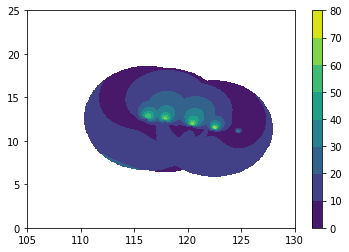

In [16]:
plt.contourf(X1,Y1,np.nanmax(np.abs(a),axis=0))
plt.ylim((0,25))
plt.xlim((105,130))
plt.colorbar()

In [25]:
plt.figure(figsize=(15, 15))
ax1 = plt.scatter(X1,Y1,c= grid)
ax1 = plt.scatter(x1,y1)
plt.ylim((10,12))
plt.xlim((115,117))

NameError: name 'X1' is not defined

<Figure size 1080x1080 with 0 Axes>

In [172]:
# ISSUES TO FIX
# Add in radial velocity to wind speed
# Make sure flow direction is oriented properly
# some storms not converging properly
# Does one get same wind field regardless of what is set as radius?

# NOTES
# iir and iit are places in wind field closest to POI

27

In [50]:
for iin in np.arange(0,iipoin,1):
    print(vlat[iin,iir[iin],iit[iin]])

11.523289225251421
14.593440232569318
14.59895085517125
14.60437679592959
14.580407983963502


In [51]:
for iin in np.arange(0,iipoin,1):
    print(vlon[iin,iir[iin],iit[iin]])

124.18541995749617
120.97050223904992
120.98337937347507
120.98013051234588
120.99203225914452


In [61]:
# Calculate maximum wind speed over Hurricane over POI
v_max_poi = []
for iin in range(iipoin):
    v_max_poi.append(np.abs(V[iin,iir[iin],iit[iin]]))
np.max(v_max_poi)

23.052935027881404

Text(0.5, 1.0, 'Typhoon Haiyan Wind Field, 11/8/13 Noon')

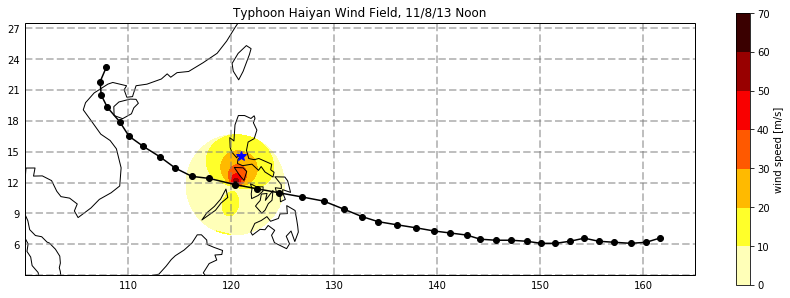

In [63]:
plt.figure(figsize=(15, 5))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
iin = 2
p1 = plt.contourf(vlon[iin,...],vlat[iin,...],np.abs(V[iin,...]),cmap=plt.cm.hot_r)
plt.plot(lon[:, iS], lat[:, iS],marker='o',color='k')
plt.plot(np.array(lon[ii,iS]),np.array(lat[ii,iS]),marker = 'o',markersize=2,color='k')
plt.plot(np.array(lon_poi),np.array(lat_poi),marker = '*',markersize=10,color='b')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines()
ax.set_extent([100, 165, 3, 24])
cbar = plt.colorbar(p1)
cbar.set_label('wind speed [m/s]', rotation=90)

plt.title('Typhoon Haiyan Wind Field, 11/8/13 Noon')

Text(0.5, 1.0, 'Typhoon Haiyan Wind Field, 11/8/13 Noon')

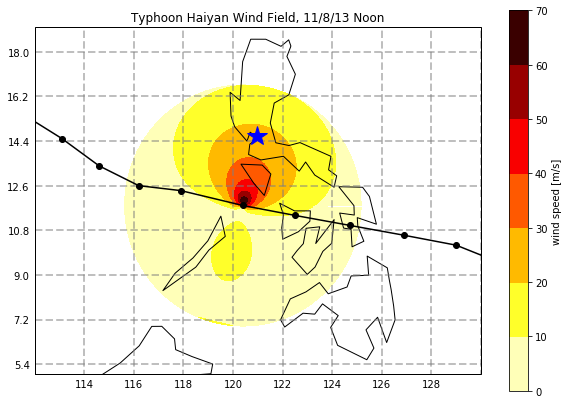

In [12]:
plt.figure(figsize=(10, 7))
ax = plt.subplot(111, projection=ccrs.PlateCarree())

iin = 2
p1 = plt.contourf(vlon[iin,...],vlat[iin,...],np.abs(V[iin,...]),cmap=plt.cm.hot_r)
plt.plot(lon[:, iS], lat[:, iS],marker='o',color='k')
plt.plot(np.array(lon[ii,iS]),np.array(lat[ii,iS]),marker = 'o',markersize=2,color='k')
plt.plot(np.array(lon_poi),np.array(lat_poi),marker = '*',markersize=20,color='b')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines()
ax.set_extent([112, 130, 5, 19])
cbar = plt.colorbar(p1)
cbar.set_label('wind speed [m/s]', rotation=90)

plt.title('Typhoon Haiyan Wind Field, 11/8/13 Noon')

In [ ]:
v_poi = np.array(v_poi)
wspd_poi = np.array(wspd_poi)
with open('Obs_Mumbai_poi_knaff15_onePt.pik', 'w+') as f:
    pickle.dump(lon, f)
    pickle.dump(lat, f)
    pickle.dump(wspd, f)
    pickle.dump(v_poi, f)
    pickle.dump(wspd_poi, f)
    pickle.dump(wspd_poi_v2, f)
    pickle.dump(rmw_poi, f)
f.close()


#!/usr/bin/env python
from __future__ import division
from builtins import str
from builtins import range
from past.utils import old_div
import numpy as np
import datetime
import pickle
from netCDF4 import Dataset
import sys
import matplotlib.pyplot as plt
from chaz import CLE15, utility
from pygplib import readbst
import xarray as xr
import pandas as pd